<table border="0">
    <tr>
        <td>
            <img src="https://ictd2016.files.wordpress.com/2016/04/microsoft-research-logo-copy.jpg" style="width 30px;" />
             </td>
        <td>
            <img src="https://www.microsoft.com/en-us/research/wp-content/uploads/2016/12/MSR-ALICE-HeaderGraphic-1920x720_1-800x550.jpg" style="width 100px;"/></td>
        </tr>
</table>

# Double Machine Learning: Use Cases and Examples

Double Machine Learning (DML) is an algorithm that applies arbitrary machine learning methods
to fit the treatment and response, then uses a linear model to predict the response residuals
from the treatment residuals.

The EconML SDK implements the following DML classes:
* LinearDML: suitable for estimating heterogeneous treatment effects.
* SparseLinearDML: suitable for the case when $W$ is high dimensional vector and both the first stage and second stage estimate are linear.

In ths notebook, we show the performance of the DML on both synthetic data and observational data.

**Notebook contents:**

1. Example usage with single continuous treatment synthetic data
2. Example usage with single binary treatment synthetic data
3. Example usage with multiple continuous treatment synthetic data
4. Example usage with single continuous treatment observational data
5. Example usage with multiple continuous treatment, multiple outcome observational data

In [2]:
## Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Main imports
from econml.dml import DML, LinearDML, SparseLinearDML, CausalForestDML

# Helper imports
import numpy as np
from itertools import product
from sklearn.linear_model import (Lasso, MultiTaskElasticNetCV)
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

## 1. Example Usage with Single Continuous Treatment Synthetic Data and Model Selection

### 1.1. DGP 
We use the data generating process (DGP) from [here](https://arxiv.org/abs/1806.03467). The DGP is described by the following equations:

\begin{align}
T =& \langle W, \beta\rangle + \eta, & \;\eta \sim \text{Uniform}(-1, 1)\\
Y =& T\cdot \theta(X) + \langle W, \gamma\rangle + \epsilon, &\; \epsilon \sim \text{Uniform}(-1, 1)\\
W \sim& \text{Normal}(0,\, I_{n_w})\\
X \sim& \text{Uniform}(0,1)^{n_x}
\end{align}

where $W$ is a matrix of high-dimensional confounders and $\beta, \gamma$ have high sparsity.

For this DGP, 
\begin{align}
\theta(x) = \exp(2\cdot x_1).
\end{align}

In [4]:
# Treatment effect function
def exp_te(x):
    return np.exp(2*x[0])

In [5]:
# DGP constants
np.random.seed(123)
n = 2000
n_w = 30
support_size = 5
n_x = 1
# Outcome support
support_Y = np.random.choice(np.arange(n_w), size=support_size, replace=False)
coefs_Y = np.random.uniform(0, 1, size=support_size)
def epsilon_sample(n):
    return np.random.uniform(-1, 1, size=n)
# Treatment support
support_T = support_Y
coefs_T = np.random.uniform(0, 1, size=support_size)
def eta_sample(n):
    return np.random.uniform(-1, 1, size=n)

# Generate controls, covariates, treatments and outcomes
W = np.random.normal(0, 1, size=(n, n_w))
X = np.random.uniform(0, 1, size=(n, n_x))
# Heterogeneous treatment effects
TE = np.array([exp_te(x_i) for x_i in X])
T = np.dot(W[:, support_T], coefs_T) + eta_sample(n)
Y = TE * T + np.dot(W[:, support_Y], coefs_Y) + epsilon_sample(n)

Y_train, Y_val, T_train, T_val, X_train, X_val, W_train, W_val = train_test_split(Y, T, X, W, test_size=.2)
# Generate test data
X_test = np.array(list(product(np.arange(0, 1, 0.01), repeat=n_x)))

### 1.2. Train Estimator
We train models in three different ways, and compare their performance.


#### 1.2.1. Default Setting

In [6]:
est = LinearDML(model_y=RandomForestRegressor(),
                model_t=RandomForestRegressor(),
                random_state=123)
est.fit(Y_train, T_train, X=X_train, W=W_train)
te_pred = est.effect(X_test)

#### 1.2.2. Polynomial Features for Heterogeneity

In [7]:
est1 = SparseLinearDML(model_y=RandomForestRegressor(),
                       model_t=RandomForestRegressor(),
                       featurizer=PolynomialFeatures(degree=3),
                       random_state=123)
est1.fit(Y_train, T_train, X=X_train, W=W_train)
te_pred1 = est1.effect(X_test)

The number of features in the final model (< 5) is too small for a sparse model. We recommend using the LinearDML estimator for this low-dimensional setting.


#### 1.2.3. Polynomial Features with regularization 

In [8]:
est2 = DML(model_y=RandomForestRegressor(),
           model_t=RandomForestRegressor(),
           model_final=Lasso(alpha=0.1, fit_intercept=False),
           featurizer=PolynomialFeatures(degree=10),
           random_state=123)
est2.fit(Y_train, T_train, X=X_train, W=W_train)
te_pred2 = est2.effect(X_test)

#### 1.2.4 Non-Parametric Heterogeneity with Causal Forest

In [9]:
est3 = CausalForestDML(model_y=RandomForestRegressor(),
                       model_t=RandomForestRegressor(),
                       criterion='mse', n_estimators=1000,
                       min_impurity_decrease=0.001,
                       random_state=123)
est3.tune(Y_train, T_train, X=X_train, W=W_train)
est3.fit(Y_train, T_train, X=X_train, W=W_train)
te_pred3 = est3.effect(X_test)

### 1.3. Performance Visualization

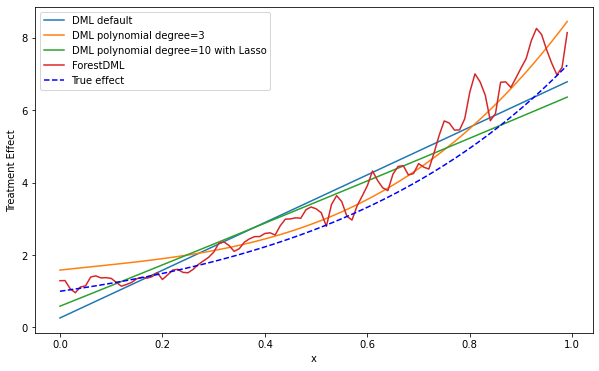

In [10]:
plt.figure(figsize=(10,6))
plt.plot(X_test, te_pred, label='DML default')
plt.plot(X_test, te_pred1, label='DML polynomial degree=3')
plt.plot(X_test, te_pred2, label='DML polynomial degree=10 with Lasso')
plt.plot(X_test, te_pred3, label='ForestDML')
expected_te = np.array([exp_te(x_i) for x_i in X_test])
plt.plot(X_test, expected_te, 'b--', label='True effect')
plt.ylabel('Treatment Effect')
plt.xlabel('x')
plt.legend()
plt.show()

### 1.4. Model selection

For the three different models above, we can use score function to estimate the final model performance. The score is the MSE of the final stage Y residual, which can be seen as a proxy of the MSE of treatment effect.

In [11]:
score={}
score["DML default"] = est.score(Y_val, T_val, X_val, W_val)
score["DML polynomial degree=3"] = est1.score(Y_val, T_val, X_val, W_val)
score["DML polynomial degree=10 with Lasso"] = est2.score(Y_val, T_val, X_val, W_val)
score["ForestDML"] = est3.score(Y_val, T_val, X_val, W_val)
score

{'DML default': 1.815769478666336,
 'DML polynomial degree=3': 1.6913528143752934,
 'DML polynomial degree=10 with Lasso': 2.222578476206349,
 'ForestDML': 1.9002757666765648}

In [12]:
print("best model selected by score: ",min(score,key=lambda x: score.get(x)))

best model selected by score:  DML polynomial degree=3


In [13]:
mse_te={}
mse_te["DML default"] = ((expected_te - te_pred)**2).mean()
mse_te["DML polynomial degree=3"] = ((expected_te - te_pred1)**2).mean()
mse_te["DML polynomial degree=10 with Lasso"] = ((expected_te - te_pred2)**2).mean()
mse_te["ForestDML"] = ((expected_te - te_pred3)**2).mean()
mse_te

{'DML default': 0.3565984526892961,
 'DML polynomial degree=3': 0.257796113358552,
 'DML polynomial degree=10 with Lasso': 0.26248739267870214,
 'ForestDML': 0.42857317657348887}

In [14]:
print("best model selected by MSE of TE: ", min(mse_te, key=lambda x: mse_te.get(x)))

best model selected by MSE of TE:  DML polynomial degree=3


### 1.5 Changing only Final Stage Model Specification and Refitting

It is also feasible to change the parameters of the estimator and only fit the final stage model using the existing first stage residual calculation. To enable this feature, the `fit` method should be called with the flag `cache_values=True`, so that the original fit data and their corresponding first stage estimates be stored in the model. This can be done for any estimator in the dml module. We portray an example below, using the `DML` estimator.

In [15]:
est = DML(model_y=RandomForestRegressor(),
          model_t=RandomForestRegressor(),
          model_final=Lasso(alpha=0.1, fit_intercept=False),
          featurizer=PolynomialFeatures(degree=1, include_bias=False),
          random_state=123)
est.fit(Y_train, T_train, X=X_train, W=W_train, cache_values=True)
est.summary()

Final model doesn't have a `coef_stderr_` and `intercept_stderr_` attributes, only point estimates will be available.
Final model doesn't have a `coef_stderr_` and `intercept_stderr_` attributes, only point estimates will be available.


,point_estimate
X0,5.953
,point_estimate
cate_intercept,0.5


In [16]:
from econml.sklearn_extensions.linear_model import DebiasedLasso
est.featurizer = PolynomialFeatures(degree=2, include_bias=False)
est.model_final = DebiasedLasso(fit_intercept=False)
est.refit_final()
est.summary()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X0,-0.054,0.685,-0.079,0.937,-1.18,1.072
X0^2,7.253,0.695,10.437,0.0,6.11,8.396
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,1.289,0.154,8.374,0.0,1.036,1.542


In [17]:
from econml.sklearn_extensions.linear_model import StatsModelsLinearRegression
est.model_final = StatsModelsLinearRegression(fit_intercept=False)
est.refit_final()
est.summary()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X0,-0.068,0.759,-0.089,0.929,-1.316,1.18
X0^2,7.26,0.744,9.761,0.0,6.037,8.484
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,1.29,0.159,8.116,0.0,1.029,1.552


In [18]:
from econml.sklearn_extensions.linear_model import StatsModelsRLM
est.model_final = StatsModelsRLM(fit_intercept=False)
est.fit_cate_intercept = False
est.refit_final()
est.summary()

CATE Intercept Results:  No intercept was fitted!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X0,5.566,0.347,16.029,0.0,4.995,6.137
X0^2,2.243,0.451,4.975,0.0,1.501,2.984


In [19]:
est.model_final = Lasso(fit_intercept=False)
est.refit_final()
est.effect_inference(X).population_summary()

Final model doesn't have a `prediction_stderr` method, only point estimates will be returned.


## 2. Example Usage with Single Binary Treatment Synthetic Data and Confidence Intervals

### 2.1. DGP 
We use the following DGP:

\begin{align}
T \sim & \text{Bernoulli}\left(f(W)\right), &\; f(W)=\sigma(\langle W, \beta\rangle + \eta), \;\eta \sim \text{Uniform}(-1, 1)\\
Y = & T\cdot \theta(X) + \langle W, \gamma\rangle + \epsilon, & \; \epsilon \sim \text{Uniform}(-1, 1)\\
W \sim & \text{Normal}(0,\, I_{n_w}) & \\
X \sim & \text{Uniform}(0,\, 1)^{n_x}
\end{align}

where $W$ is a matrix of high-dimensional confounders, $\beta, \gamma$ have high sparsity and $\sigma$ is the sigmoid function.

For this DGP, 
\begin{align}
\theta(x) = \exp( 2\cdot x_1 ).
\end{align}

In [20]:
# Treatment effect function
def exp_te(x):
    return np.exp(2 * x[0])# DGP constants

np.random.seed(123)
n = 1000
n_w = 30
support_size = 5
n_x = 4
# Outcome support
support_Y = np.random.choice(range(n_w), size=support_size, replace=False)
coefs_Y = np.random.uniform(0, 1, size=support_size)
def epsilon_sample(n):
    return np.random.uniform(-1, 1, size=n)
# Treatment support
support_T = support_Y
coefs_T = np.random.uniform(0, 1, size=support_size)
def eta_sample(n):
    return np.random.uniform(-1, 1, size=n)

# Generate controls, covariates, treatments and outcomes
W = np.random.normal(0, 1, size=(n, n_w))
X = np.random.uniform(0, 1, size=(n, n_x))
# Heterogeneous treatment effects
TE = np.array([exp_te(x_i) for x_i in X])
# Define treatment
log_odds = np.dot(W[:, support_T], coefs_T) + eta_sample(n)
T_sigmoid = 1/(1 + np.exp(-log_odds))
T = np.array([np.random.binomial(1, p) for p in T_sigmoid])
# Define the outcome
Y = TE * T + np.dot(W[:, support_Y], coefs_Y) + epsilon_sample(n)

# get testing data
X_test = np.random.uniform(0, 1, size=(n, n_x))
X_test[:, 0] = np.linspace(0, 1, n)

### 2.2. Train Estimator

In [21]:
est = LinearDML(model_y=RandomForestRegressor(),
                model_t=RandomForestClassifier(min_samples_leaf=10),
                discrete_treatment=True,
                cv=6)
est.fit(Y, T, X=X, W=W)
te_pred = est.effect(X_test)
lb, ub = est.effect_interval(X_test, alpha=0.01)

In [22]:
est2 = SparseLinearDML(model_y=RandomForestRegressor(),
                       model_t=RandomForestClassifier(min_samples_leaf=10),
                       discrete_treatment=True,
                       featurizer=PolynomialFeatures(degree=2),
                       cv=6)
est2.fit(Y, T, X=X, W=W)
te_pred2 = est2.effect(X_test)
lb2, ub2 = est2.effect_interval(X_test, alpha=0.01)

In [23]:
est3 = CausalForestDML(model_y=RandomForestRegressor(),
                       model_t=RandomForestClassifier(min_samples_leaf=10),
                       discrete_treatment=True,
                       n_estimators=1000,
                       min_impurity_decrease=0.001,
                       verbose=0,
                       cv=6)
est3.tune(Y, T, X=X, W=W)
est3.fit(Y, T, X=X, W=W)
te_pred3 = est3.effect(X_test)
lb3, ub3 = est3.effect_interval(X_test, alpha=0.01)

In [24]:
est3.feature_importances_

array([0.99117512, 0.00264324, 0.00244716, 0.00373448])

### 2.3. Performance Visualization

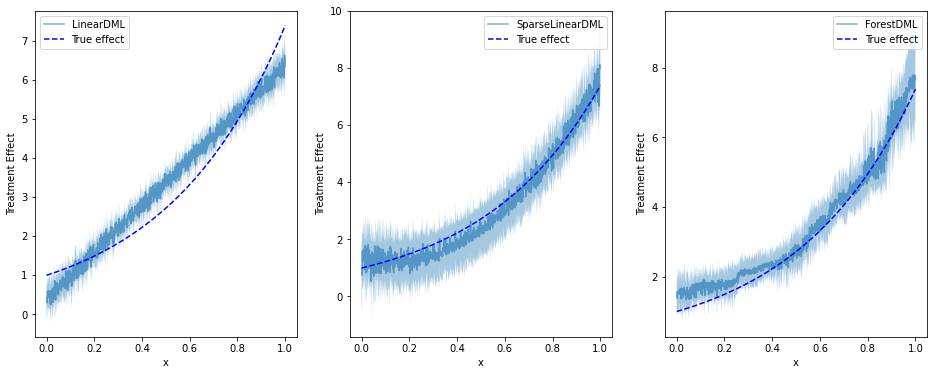

In [25]:
expected_te=np.array([exp_te(x_i) for x_i in X_test])
plt.figure(figsize=(16,6))
plt.subplot(1, 3, 1)
plt.plot(X_test[:, 0], te_pred, label='LinearDML', alpha=.6)
plt.fill_between(X_test[:, 0], lb, ub, alpha=.4)
plt.plot(X_test[:, 0], expected_te, 'b--', label='True effect')
plt.ylabel('Treatment Effect')
plt.xlabel('x')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(X_test[:, 0], te_pred2, label='SparseLinearDML', alpha=.6)
plt.fill_between(X_test[:, 0], lb2, ub2, alpha=.4)
plt.plot(X_test[:, 0], expected_te, 'b--', label='True effect')
plt.ylabel('Treatment Effect')
plt.xlabel('x')
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(X_test[:, 0], te_pred3, label='ForestDML', alpha=.6)
plt.fill_between(X_test[:, 0], lb3, ub3, alpha=.4)
plt.plot(X_test[:, 0], expected_te, 'b--', label='True effect')
plt.ylabel('Treatment Effect')
plt.xlabel('x')
plt.legend()
plt.show()

### 2.4 Interpretability with SHAP Values

Explain the heterogeneity model for the constant marginal effect of the treatment using <a href="https://shap.readthedocs.io/en/latest/">SHAP values</a>.

In [26]:
import shap

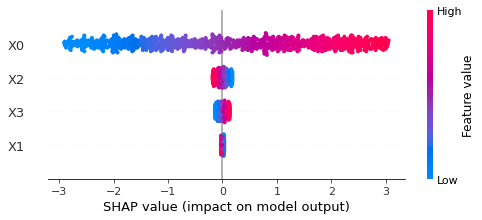

In [27]:
shap_values = est.shap_values(X)
shap.plots.beeswarm(shap_values['Y0']['T0_1'])

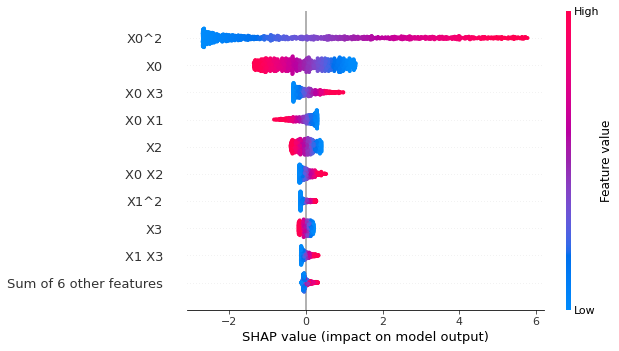

In [28]:
shap_values2 = est2.shap_values(X)
shap.plots.beeswarm(shap_values2['Y0']['T0_1'])

 98%|===================| 983/1000 [00:54<00:00]        

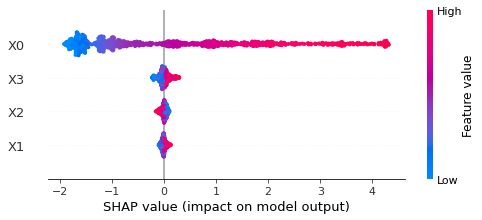

In [29]:
shap_values3 = est3.shap_values(X)
shap.plots.beeswarm(shap_values3['Y0']['T0_1'])
plt.show()

### 2.5. Other Inferences
#### 2.5.1 Effect Inferences
Other than confidence interval, we could also output other statistical inferences of the effect include standard error, z-test score and p value given each sample $X[i]$.

In [30]:
est.effect_inference(X_test[:10,]).summary_frame(alpha=0.1, value=0, decimals=3)

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
0,0.372,0.146,2.540,0.011,0.131,0.613
1,0.416,0.163,2.553,0.011,0.148,0.683
2,0.291,0.170,1.709,0.087,0.011,0.571
3,0.410,0.150,2.733,0.006,0.163,0.656
4,0.584,0.152,3.834,0.000,0.333,0.834
5,0.553,0.139,3.974,0.000,0.324,0.782
6,0.430,0.124,3.472,0.001,0.226,0.634
7,0.605,0.154,3.921,0.000,0.351,0.859
8,0.439,0.127,3.471,0.001,0.231,0.647


We could also get the population inferences given sample $X$.

In [31]:
est.effect_inference(X_test).population_summary(alpha=0.1, value=0, decimals=3, tol=0.001)

#### 2.5.2 Coefficient and Intercept Inferences
We could also get the coefficient and intercept inference for the final model when it's linear.

In [32]:
est.coef__inference().summary_frame()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
X0,5.969,0.229,26.053,0.000,5.592,6.346
X1,-0.060,0.216,-0.277,0.782,-0.415,0.295
X2,-0.363,0.219,-1.660,0.097,-0.722,-0.003
X3,0.271,0.212,1.280,0.201,-0.077,0.620


In [33]:
est.intercept__inference().summary_frame()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
cate_intercept,0.456,0.218,2.09,0.037,0.097,0.815


In [34]:
est.summary()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X0,5.969,0.229,26.053,0.0,5.592,6.346
X1,-0.06,0.216,-0.277,0.782,-0.415,0.295
X2,-0.363,0.219,-1.66,0.097,-0.722,-0.003
X3,0.271,0.212,1.28,0.201,-0.077,0.62
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,0.456,0.218,2.09,0.037,0.097,0.815


#### 2.5.3 Doubly Robust Average Treatment Effect Inference

For the case of `CausalForestDML`, the estimator also fits a doubly robust average treatment effect at fit time. This inference result can be accessed as follows:

In [36]:
est3.ate_

array([3.53511397])

In [37]:
est3.ate__inference().summary_frame()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATE,3.535,0.079,44.671,0.0,3.405,3.665


## 3. Example Usage with Multiple Continuous Treatment Synthetic Data

### 3.1. DGP 
We use the data generating process (DGP) from [here](https://arxiv.org/abs/1806.03467), and modify the treatment to generate multiple treatments. The DGP is described by the following equations:

\begin{align}
T =& \langle W, \beta\rangle + \eta, & \;\eta \sim \text{Uniform}(-1, 1)\\
Y =& T\cdot \theta_{1}(X) + T^{2}\cdot \theta_{2}(X) + \langle W, \gamma\rangle + \epsilon, &\; \epsilon \sim \text{Uniform}(-1, 1)\\
W \sim& \text{Normal}(0,\, I_{n_w})\\
X \sim& \text{Uniform}(0,1)^{n_x}
\end{align}

where $W$ is a matrix of high-dimensional confounders and $\beta, \gamma$ have high sparsity.

For this DGP, 
\begin{align}
\theta_{1}(x) = \exp(2\cdot x_1)\\
\theta_{2}(x) = x_1^{2}\\
\end{align}

In [35]:
# DGP constants
np.random.seed(123)
n = 6000
n_w = 30
support_size = 5
n_x = 5
# Outcome support
support_Y = np.random.choice(np.arange(n_w), size=support_size, replace=False)
coefs_Y = np.random.uniform(0, 1, size=support_size)
def epsilon_sample(n):
    return np.random.uniform(-1, 1, size=n)
# Treatment support
support_T = support_Y
coefs_T = np.random.uniform(0, 1, size=support_size)
def eta_sample(n):
    return np.random.uniform(-1, 1, size=n)

# Generate controls, covariates, treatments and outcomes
W = np.random.normal(0, 1, size=(n, n_w))
X = np.random.uniform(0, 1, size=(n, n_x))
# Heterogeneous treatment effects
TE1 = np.array([x_i[0] for x_i in X])
TE2 = np.array([x_i[0]**2 for x_i in X]).flatten()
T = np.dot(W[:, support_T], coefs_T) + eta_sample(n)
Y = TE1 * T + TE2 * T**2 + np.dot(W[:, support_Y], coefs_Y) + epsilon_sample(n)
# Generate test data
X_test = np.random.uniform(0, 1, size=(100, n_x))
X_test[:, 0] = np.linspace(0, 1, 100)

### 3.2. Train Estimator

In [36]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
est = LinearDML(model_y=GradientBoostingRegressor(n_estimators=100, max_depth=3, min_samples_leaf=20),
                model_t=MultiOutputRegressor(GradientBoostingRegressor(n_estimators=100,
                                                                       max_depth=3,
                                                                       min_samples_leaf=20)),
                featurizer=PolynomialFeatures(degree=2, include_bias=False),
                cv=5)

In [37]:
T = T.reshape(-1,1)
est.fit(Y, np.concatenate((T, T**2), axis=1), X=X, W=W)

In [38]:
te_pred = est.const_marginal_effect(X_test)

In [39]:
lb, ub = est.const_marginal_effect_interval(X_test, alpha=0.01)

In [40]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
est2 = CausalForestDML(model_y=GradientBoostingRegressor(n_estimators=100, max_depth=3, min_samples_leaf=20),
                       model_t=MultiOutputRegressor(GradientBoostingRegressor(n_estimators=100,
                                                                              max_depth=3,
                                                                              min_samples_leaf=20)),
                       cv=5,
                       criterion='mse', n_estimators=1000,
                       min_samples_leaf=10,
                       min_impurity_decrease=0.001,
                       random_state=123)
T = T.reshape(-1,1)
est2.tune(Y, np.concatenate((T, T**2), axis=1), X=X, W=W)
est2.fit(Y, np.concatenate((T, T**2), axis=1), X=X, W=W)

In [41]:
te_pred2 = est2.const_marginal_effect(X_test)

In [42]:
lb2, ub2 = est2.const_marginal_effect_interval(X_test, alpha=0.01)

### 3.3. Performance Visualization

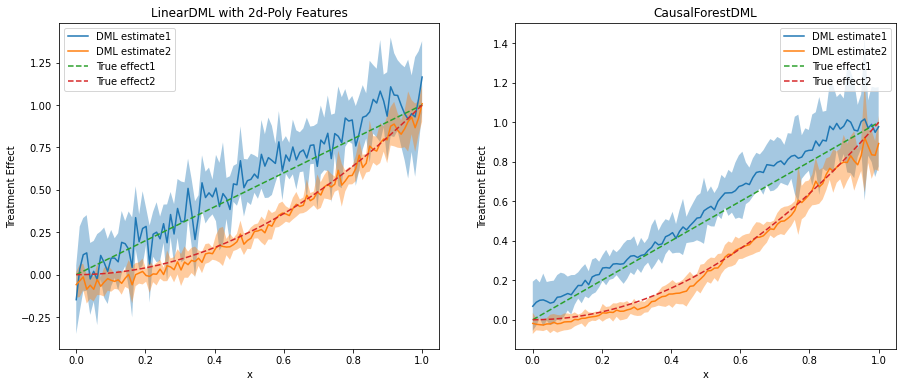

In [43]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.title("LinearDML with 2d-Poly Features")
plt.plot(X_test[:, 0], te_pred[:, 0], label='DML estimate1')
plt.fill_between(X_test[:, 0], lb[:, 0], ub[:, 0], alpha=.4)
plt.plot(X_test[:, 0], te_pred[:, 1], label='DML estimate2')
plt.fill_between(X_test[:, 0], lb[:, 1], ub[:, 1], alpha=.4)
expected_te1 = np.array([x_i[0] for x_i in X_test])
expected_te2=np.array([x_i[0]**2 for x_i in X_test]).flatten()
plt.plot(X_test[:, 0], expected_te1, '--', label='True effect1')
plt.plot(X_test[:, 0], expected_te2, '--', label='True effect2')
plt.ylabel("Treatment Effect")
plt.xlabel("x")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("CausalForestDML")
plt.plot(X_test[:, 0], te_pred2[:, 0], label='DML estimate1')
plt.fill_between(X_test[:, 0], lb2[:, 0], ub2[:, 0], alpha=.4)
plt.plot(X_test[:, 0], te_pred2[:, 1], label='DML estimate2')
plt.fill_between(X_test[:, 0], lb2[:, 1], ub2[:, 1], alpha=.4)
expected_te1 = np.array([x_i[0] for x_i in X_test])
expected_te2=np.array([x_i[0]**2 for x_i in X_test]).flatten()
plt.plot(X_test[:, 0], expected_te1, '--', label='True effect1')
plt.plot(X_test[:, 0], expected_te2, '--', label='True effect2')
plt.ylabel("Treatment Effect")
plt.xlabel("x")
plt.legend()
plt.show()

### 3.4 Tree Interpreter

Interpreting heterogeneity via a tree based rule.

In [44]:
from econml.cate_interpreter import SingleTreeCateInterpreter

intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2)
intrp.interpret(est, X)

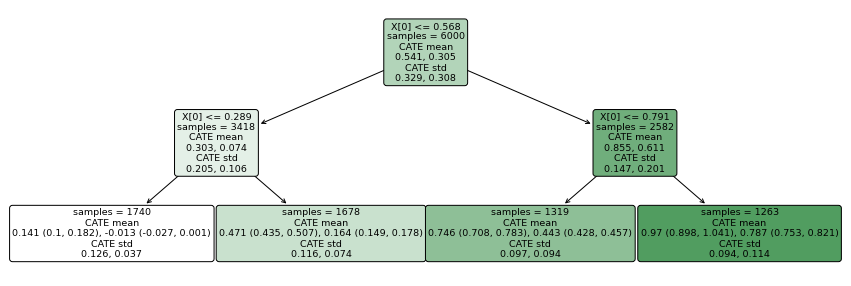

In [45]:
plt.figure(figsize=(15, 5))
intrp.plot()
plt.show()

## 4. Example Usage with Single Continuous Treatment Observational Data

We applied our technique to Dominick’s dataset, a popular historical dataset of store-level orange juice prices and sales provided by University of Chicago Booth School of Business. 

The dataset is comprised of a large number of covariates $W$, but researchers might only be interested in learning the elasticity of demand as a function of a few variables $x$ such
as income or education. 

We applied the `LinearDML` to estimate orange juice price elasticity
as a function of income, and our results, unveil the natural phenomenon that lower income consumers are more price-sensitive.

### 4.1. Data

In [46]:
# A few more imports
import os
import pandas as pd
import urllib.request
from sklearn.preprocessing import StandardScaler

In [47]:
# Import the data
file_name = "oj_large.csv"

if not os.path.isfile(file_name):
    print("Downloading file (this might take a few seconds)...")
    urllib.request.urlretrieve("https://raw.githubusercontent.com/py-why/EconML/refs/heads/data/datasets/OrangeJuice/oj_large.csv",
                               file_name)
oj_data = pd.read_csv(file_name)

In [48]:
oj_data.head()

,store,brand,week,logmove,feat,price,AGE60,EDUC,ETHNIC,INCOME,HHLARGE,WORKWOM,HVAL150,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5
0,2,tropicana,40,9.018695,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
1,2,tropicana,46,8.723231,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
2,2,tropicana,47,8.253228,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
3,2,tropicana,48,8.987197,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
4,2,tropicana,50,9.093357,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927


In [49]:
# Prepare data
Y = oj_data['logmove'].values
T = np.log(oj_data["price"]).values
scaler = StandardScaler()
W1 = scaler.fit_transform(oj_data[[c for c in oj_data.columns
                                   if c not in ['price', 'logmove', 'brand', 'week', 'store','INCOME']]].values)
W2 = pd.get_dummies(oj_data[['brand']]).values
W = np.concatenate([W1, W2], axis=1)
X=scaler.fit_transform(oj_data[['INCOME']].values)

In [50]:
## Generate test data
min_income = -1
max_income = 1
delta = (1 - (-1)) / 100
X_test = np.arange(min_income, max_income + delta - 0.001, delta).reshape(-1,1)

### 4.2. Train Estimator

In [51]:
est = LinearDML(model_y=RandomForestRegressor(),model_t=RandomForestRegressor())
est.fit(Y, T, X=X, W=W)
te_pred=est.effect(X_test)

### 4.3. Performance Visualization

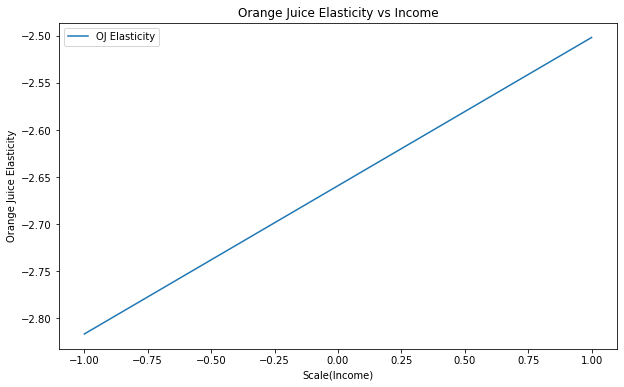

In [52]:
# Plot Oranje Juice elasticity as a function of income
plt.figure(figsize=(10,6))
plt.plot(X_test, te_pred, label="OJ Elasticity")
plt.xlabel(r'Scale(Income)')
plt.ylabel('Orange Juice Elasticity')
plt.legend()
plt.title("Orange Juice Elasticity vs Income")
plt.show()

### 4.4. Confidence Intervals

We can also get confidence intervals around our predictions by passing an additional `inference` argument to `fit`.  All estimators support bootstrap intervals, which involves refitting the same estimator repeatedly on subsamples of the original data, but `LinearDML` also supports a more efficient approach which can be achieved by leaving inference set to the default of `'auto'` or by explicitly passing `inference='statsmodels'`.

In [53]:
est.fit(Y, T, X=X, W=W)
te_pred=est.effect(X_test)
te_pred_interval = est.const_marginal_effect_interval(X_test, alpha=0.02)

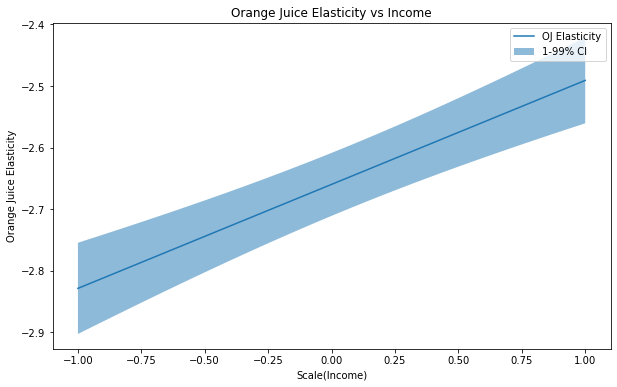

In [54]:
# Plot Oranje Juice elasticity as a function of income
plt.figure(figsize=(10,6))
plt.plot(X_test.flatten(), te_pred, label="OJ Elasticity")
plt.fill_between(X_test.flatten(), te_pred_interval[0], te_pred_interval[1], alpha=.5, label="1-99% CI")
plt.xlabel(r'Scale(Income)')
plt.ylabel('Orange Juice Elasticity')
plt.title("Orange Juice Elasticity vs Income")
plt.legend()
plt.show()

## 5. Example Usage with Multiple Continuous Treatment, Multiple Outcome Observational Data

We use the same data, but in this case, we want to fit the demand of multiple brand as a function of the price of each one of them, i.e. fit the matrix of cross price elasticities. It can be done, by simply setting as $Y$ to be the vector of demands and $T$ to be the vector of prices. Then we can obtain the matrix of cross price elasticities.

\begin{align}
Y=[Logmove_{tropicana},Logmove_{minute.maid},Logmove_{dominicks}] \\
T=[Logprice_{tropicana},Logprice_{minute.maid},Logprice_{dominicks}] \\
\end{align}


### 5.1. Data

In [55]:
# Import the data
oj_data = pd.read_csv(file_name)

In [56]:
# Prepare data
oj_data['price'] = np.log(oj_data["price"])
# Transform dataset.
# For each store in each week, get a vector of logmove and a vector of logprice for each brand.
# Other features are store specific, will be the same for all brands.
groupbylist = ["store", "week", "AGE60", "EDUC", "ETHNIC", "INCOME",
               "HHLARGE", "WORKWOM", "HVAL150",
               "SSTRDIST", "SSTRVOL", "CPDIST5", "CPWVOL5"]
oj_data1 = pd.pivot_table(oj_data,index=groupbylist,
                          columns=oj_data.groupby(groupbylist).cumcount(),
                          values=['logmove', 'price'],
                          aggfunc='sum').reset_index()
oj_data1.columns = oj_data1.columns.map('{0[0]}{0[1]}'.format)
oj_data1 = oj_data1.rename(index=str,
                           columns={"logmove0": "logmove_T",
                                    "logmove1": "logmove_M",
                                    "logmove2":"logmove_D",
                                    "price0":"price_T",
                                    "price1":"price_M",
                                    "price2":"price_D"})

# Define Y,T,X,W
Y = oj_data1[['logmove_T', "logmove_M", "logmove_D"]].values
T = oj_data1[['price_T', "price_M", "price_D"]].values
scaler = StandardScaler()
W=scaler.fit_transform(oj_data1[[c for c in groupbylist if c not in ['week', 'store', 'INCOME']]].values)
X=scaler.fit_transform(oj_data1[['INCOME']].values)

In [57]:
## Generate test data
min_income = -1
max_income = 1
delta = (1 - (-1)) / 100
X_test = np.arange(min_income, max_income + delta - 0.001, delta).reshape(-1, 1)

### 5.2. Train Estimator

In [58]:
est = LinearDML(model_y=MultiTaskElasticNetCV(cv=3, tol=1, selection='random'),
                model_t=MultiTaskElasticNetCV(cv=3),
                featurizer=PolynomialFeatures(1))
est.fit(Y, T, X=X, W=W)
te_pred = est.const_marginal_effect(X_test)

### 5.3. Performance Visualization

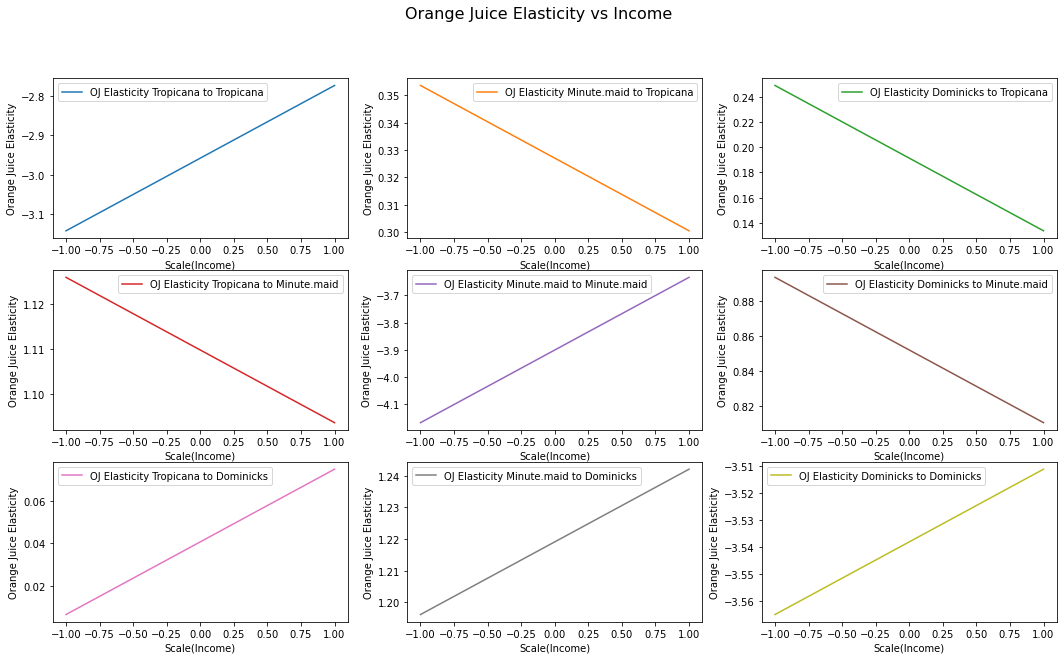

In [59]:
# Plot Oranje Juice elasticity as a function of income
plt.figure(figsize=(18, 10))
dic={0:"Tropicana", 1:"Minute.maid", 2:"Dominicks"}
for i in range(3):
    for j in range(3):
        plt.subplot(3, 3, 3 * i + j + 1)
        plt.plot(X_test, te_pred[:, i, j],
                 color="C{}".format(str(3 * i + j)),
                 label="OJ Elasticity {} to {}".format(dic[j], dic[i]))
        plt.xlabel(r'Scale(Income)')
        plt.ylabel('Orange Juice Elasticity')
        plt.legend()
plt.suptitle("Orange Juice Elasticity vs Income", fontsize=16)
plt.show()

**Findings**: Look at the diagonal of the matrix, the TE of OJ prices are always negative to the sales across all the brand, but people with higher income are less price-sensitive. By contrast, for the non-diagonal of the matrix, the TE of prices for other brands are always positive to the sales for that brand, the TE is affected by income in different ways for different competitors. In addition, compare to previous plot, the negative TE of OJ prices for each brand are all larger than the TE considering all brand together, which means we would have underestimated the effect of price changes on demand. 

### 5.4. Confidence Intervals

In [60]:
te_pred_interval = est.const_marginal_effect_interval(X_test, alpha=0.02)

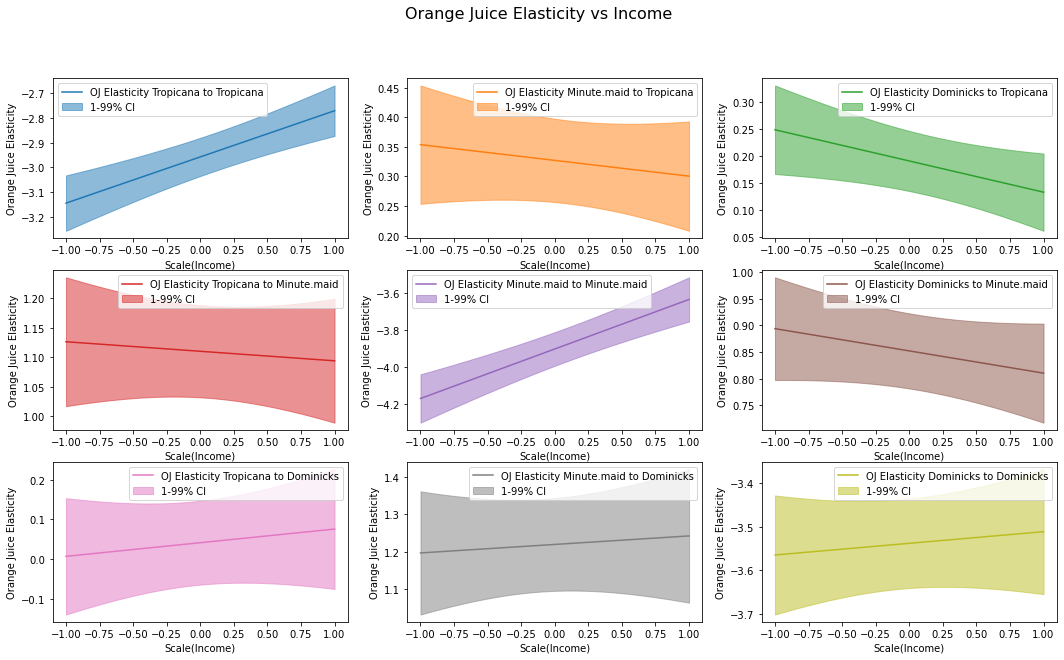

In [61]:
# Plot Oranje Juice elasticity as a function of income
plt.figure(figsize=(18, 10))
dic={0:"Tropicana", 1:"Minute.maid", 2:"Dominicks"}
for i in range(3):
    for j in range(3):
        plt.subplot(3, 3, 3 * i + j + 1)
        plt.plot(X_test, te_pred[:, i, j],
                 color="C{}".format(str(3 * i + j)),
                 label="OJ Elasticity {} to {}".format(dic[j], dic[i]))
        plt.fill_between(X_test.flatten(),
                         te_pred_interval[0][:, i, j],
                         te_pred_interval[1][:, i,j],
                         color="C{}".format(str(3*i+j)), alpha=.5, label="1-99% CI")
        plt.xlabel(r'Scale(Income)')
        plt.ylabel('Orange Juice Elasticity')
        plt.legend()
plt.suptitle("Orange Juice Elasticity vs Income",fontsize=16)
plt.show()